### MSFT Stock Price Prediction

###### By Aizaz Ur Rahman



**ARIMA** technique is used to build a model to predict the stock price of MSFT (Microsoft Corporation) for the next 30 days. The data of MSFT's stock price from July 23, 2021, to the current date, July 23, 2023, is collected from - https://finance.yahoo.com/quote/MSFT/history?period1=1626998400&period2=1690070400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true



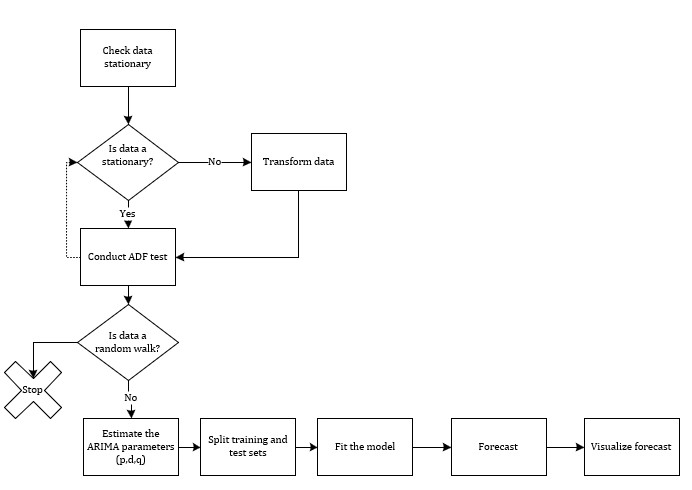<br><br>

**Time Series** refers to historical data collected at regular time intervals. Analyzing time series involves uncovering patterns within these data points and developing mathematical models to predict future values.<br>
There are many time series models, which can be used for forecasting. **ARIMA** is one of the traditional methods used for forecasting with time series analysis.<br>
In **ARIMA** **AR** stands for autoregressive, which simple means that the values at one time depends on previous values. How many past values matter has to be determined, and is usually denoted by **p**. In "AR", the next value will be predicted based on the regression of the previous p values in the time series.<br>
**I** stands for integrated and is denoted by **d**, which takes integer value for differencing time series. **d** = 1 means first differencing.<br>
**MA** is the moving average. It means the predicted value depends in the previous errors on the previous points. It is demoted by **q** to indicate how many past errors we capture to predict the future values.
to forecast properly with **ARIMA** the assumption of data stationary should hold. It means the data should have constant mean and variance. It is possible that due to random shock, the mean and variance changes, but stationary data will have such randomness fixed along with time. This phenomenon is called **mean-reversion**.


 

##### Python libraries used in the project

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [5]:
!pip install plotly

In [6]:
from pmdarima.arima import auto_arima
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots

##### Reading dataset

In [8]:
dateparse = lambda dates: datetime.strptime(dates, '%m/%d/%Y')
data = pd.read_csv('C://Users//martq//OneDrive//Desktop//Projects//MSFT Stock Prediction//MSFT.csv',index_col='Date', parse_dates = ['Date'], date_parser=dateparse).fillna(0)
data.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,287.369995,289.989990,286.500000,289.670013,284.573120,22768100
2021-07-26,289.000000,289.690002,286.640015,289.049988,283.963989,23176100


##### Checking for basic data structure

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2021-07-23 to 2023-07-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null    float64
 3   Close      502 non-null    float64
 4   Adj Close  502 non-null    float64
 5   Volume     502 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


All the data type are numeric. We have set the date columns as row index as it ease processing time series data.

##### Checking any null values

In [10]:
for col in data.columns:
    print (f' {col} has {data[col].isna().sum()} null values')


 Open has 0 null values
 High has 0 null values
 Low has 0 null values
 Close has 0 null values
 Adj Close has 0 null values
 Volume has 0 null values


The are no null values in the dataset.

##### Keep only relevant columns<br>

For our analysis, we only need index(date) and Close column of the dataset. Close is the closing price of the stock for the corresponding day.


In [12]:
timeseries= pd.DataFrame(data['Close'].copy())
timeseries.head(2)

,Close
Date,
2021-07-23,289.670013
2021-07-26,289.049988


##### Visualize the stock's daily closing price

In [14]:
fig_1 = px.line(data_frame = timeseries,
               labels = {"Value":"Closing Price"}, 
               title = "MSFT's daily closing price")

fig_1.update_traces(showlegend = False)

#### 1 Check for stationary

For **ARIMA** forecast, one key assumption is that the time series must be stationary. It is visible form above time series plot that this time series is not stationary. Both the variance and mean are changing through out the period. We validate the non-stationary of this time series by conducting Augmented Dicky Fuller (ADF) test. We can also check this using autoregressive and first-differences plots.

##### Autoregressive plot (at lagged 1)

In [15]:
fig_scatter1 = px.scatter(data_frame = timeseries, x =
                        timeseries['Close'][1:len(timeseries)-1], 
                        y= timeseries['Close'][2:len(timeseries)], 
                         title = 'Autoregressive at lag1',
                         labels = {'x': "lag1 price", 'y':"price"})
fig_scatter1.show()

We see a strong positive linear relationship. Thus, an autoregressive model is promising. However, the stock still has a strong upward trend that contradicts the first assumption of stationarity. Let's plot the first-differences in absolute values, from one day to next.

##### First difference in stock price 

In [16]:
fig_scatter2 = px.scatter(data_frame = timeseries, 
                         x= timeseries.index,
                         y =timeseries['Close'].diff(), 
                         title = "first differences in price over the time", 
                         labels = {'Y': 'first differece price'})
fig_scatter2.update_traces(marker=dict(color='blue'))
fig_scatter2.show()

The time series now has nice horizontal trend, but we notice a large increase over time in these daily differences, and later small. This should not surprise us since the stock has dramatically increased in absolute dollar price, absolute changes from one day to the next day also increased. Our second assumption of stable variance is also breached. We need to normalize these absolute price differences, and this is precisely what returns are here for. Let's calculate all the returns over the entire period by dividing the daily differences by the the values at the beginning of each day- except the last one:


#### 2 Data Transformation

##### Calculation of stock's daily returns

In [17]:
timeseries["return"]= timeseries['Close'].pct_change(1)
timeseries.head(2)

,Close,return
Date,,
2021-07-23,289.670013,NaN
2021-07-26,289.049988,-0.00214


##### Visualizing daily returns

In [18]:
fig_daily_returns = px.line(data_frame = timeseries,
                           y= "return", title = 'Stock daily returns')
fig_daily_returns.show()


From the visual analysis of Microsoft's return, it looks the return is stationary as mean is stable through out and also the variance. there are not constant large increase in variance. So, the Meta's retun looks promising to build a **ARMA** model. We use only **ARMA** because we do not need any differencing. 

##### Probability distribution to visualize the data

<AxesSubplot:title={'center':"KDE Plot of MSFT's daily returns"}, ylabel='Density'>

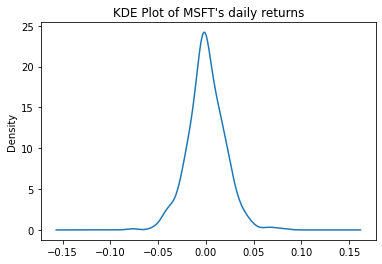

In [19]:
timeseries['return'].plot(kind = 'kde', title="KDE Plot of MSFT's daily returns")

From above KDE plot, we can conclude that the MSFT's return is stationary as mean is centered in 0 with standard deviation 1.

#### 3. Augmented Dicky- Fuller (ADF) Test

This test is used to determine whether or not a series has a unit root, and thus whether or series is stationary.

In [21]:
def test_stationarity_1(timeseries):
    import plotly.express as px # for plotly viz
    timeseries['daily return']= timeseries['return'].rolling(1).mean() 
    timeseries['std']= timeseries['return'].rolling(2).std() 
    fig1 = px.line(data_frame = timeseries,
                   y=['daily return', 'std'],
                  title ="stock's daily returns and its stadard deviation", 
                  labels = {'value': 'daily returns'})
    fig1.show()
    
    
    print ("ADF Test")
    adft = adfuller(timeseries['return'], autolag = 'AIC')
    # Output for dft will give us without defining what the values are, hence we mannualy write what values does it explains using a for loop.
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'No. of observations used' ])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    print (output)

In [22]:
data= pd.DataFrame(timeseries['return'], columns = ['return']).iloc[1:]# we delete the first row as it has no return value


In [23]:
data.head()

,return
Date,
2021-07-26,-0.002140
2021-07-27,-0.008684
2021-07-28,-0.001117
2021-07-29,0.000978
2021-07-30,-0.005550


In [24]:
test_stationarity_1(data)


ADF Test
Test Statistics            -1.464040e+01
p-value                     3.631710e-27
No. of lags used            2.000000e+00
No. of observations used    4.980000e+02
critical value (1%)        -3.443549e+00
critical value (5%)        -2.867361e+00
critical value (10%)       -2.569870e+00
dtype: float64


Since p-value is almost 0 and we reject null hypothesis that the series has unit root, or the series is non-stationary

#### 4 Estimation of the parameters (p,d,q) <br>
We already determined the value of d as we require no differencing. We will estimate the value for p and q.<br>
Using ACF and PACF plots, we estimate the parameters p and q.<br>
1. For p we use PACF (Partial Autocorrelation) plot.<br>
2. For q we use ACF (Autocorrelation) plot of stationary series<br>

##### ACF and PACF plots

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

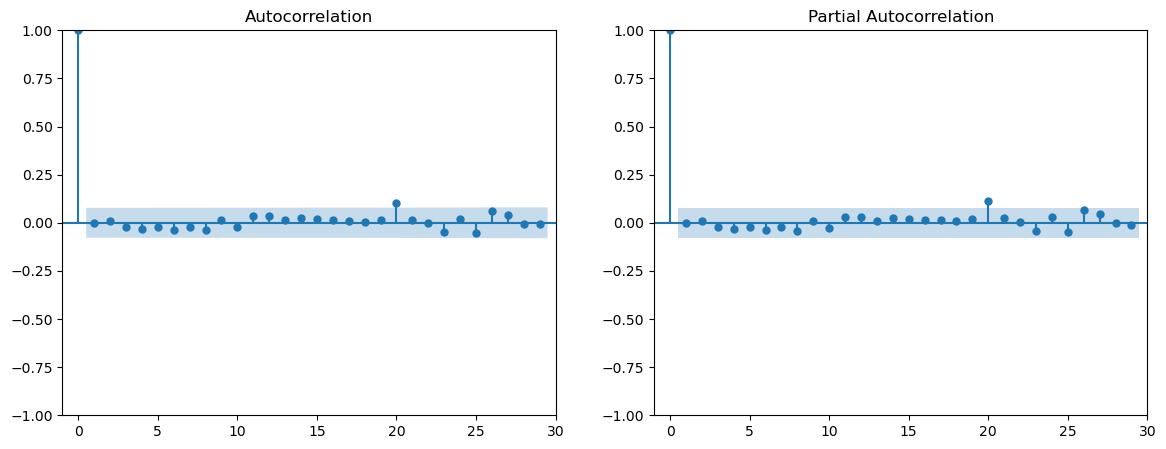

In [17]:
f = plt.figure(figsize= (14,5))
ax1 = f.add_subplot(121)
ax1.set_title('daily returns')
plot_acf(data['return'].dropna(), ax = ax1)
plt.xlim(-1,30)
plt.ylim(-1, 1)

ax2 = f.add_subplot(122)
ax2.set_title('Partial Autocorrelation')
plot_pacf(data['return'].dropna(), ax= ax2)
plt.xlim(-1, 30)
plt.ylim(-1, 1)
plt.show()

From above ACF and PACF plots, it appeared that only the 20th lags look significant. It is also possible that these spikes are just white noise. But we can take values for p and q of 20 each and see the results. 

#### 5. Split training and test dataset

For the forecase with timeseries, it is very important to not to ramdomized the the data for train, test split. We use the recent data (in series) for test and previous data (in series) for training.

In [26]:
len(data)

501

In [27]:
cut = int(len(data)*.96)
train, test = pd.DataFrame(data['return'].iloc[:cut]), pd.DataFrame(data['return'].iloc[cut:])
print (f' Total number of values in training set is {len(train)}.')
print     (f' Total number of values in test set is {len(test)}.')

 Total number of values in training set is 480.
 Total number of values in test set is 21.


In [20]:
train.head(2)

,return
Date,
2021-01-05,0.007548
2021-01-06,-0.028269


##### Visualizing training and test set

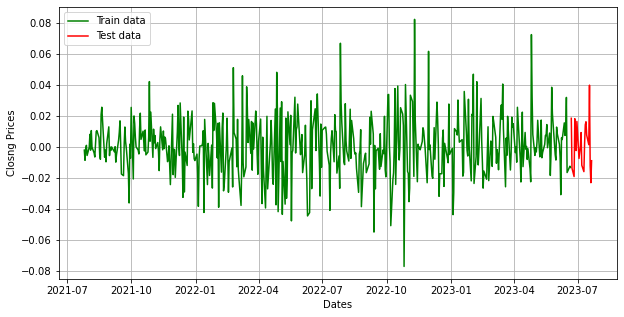

In [28]:
plt.figure(figsize = (10,5))
plt.grid (True)
plt.plot(train, 'green', label = "Train data")
plt.plot(test, 'red', label = 'Test data')
plt.xlabel ('Dates')
plt.ylabel('Closng Prices')
plt.legend()
plt.show()

6. #### Fit ARIMA Model<br>
using the estimated the parameters (p,d,q) of (20, 0, 20), we fit the ARIMA model

In [29]:
arima_model = ARIMA(train['return'], order = (20,0,20))
model = arima_model.fit()


#### 7 Forecast
using the model, we now forecast the stock price for the days equal to the test data set, which is for 26 days.<br>
Since, we only forecasted the price for test set, all the  values in the conrresponding index of training set for the forecasted column will be null. 

In [30]:
forecast_test = model.forecast(len(test))
data['forecast'] = [None]*len(train)+list(forecast_test)
print(data.tail(30))

              return  daily return       std  forecast
Date                                                  
2023-06-08  0.005814      0.005814  0.025938       NaN
2023-06-09  0.004704      0.004704  0.000785       NaN
2023-06-12  0.015484      0.015484  0.007623       NaN
2023-06-13  0.007353      0.007353  0.005750       NaN
2023-06-14  0.009124      0.009124  0.001252       NaN
2023-06-15  0.031897      0.031897  0.016103       NaN
2023-06-16 -0.016576     -0.016576  0.034275       NaN
2023-06-20 -0.012503     -0.012503  0.002880       NaN
2023-06-21 -0.013282     -0.013282  0.000551       NaN
2023-06-22  0.018437      0.018437  0.022429 -0.004798
2023-06-23 -0.013806     -0.013806  0.022799  0.000765
2023-06-26 -0.019163     -0.019163  0.003788  0.005200
2023-06-27  0.018168      0.018168  0.026397  0.000598
2023-06-28  0.003826      0.003826  0.010141  0.005415
2023-06-29 -0.002382     -0.002382  0.004390  0.008141
2023-06-30  0.016386      0.016386  0.013271 -0.006409
2023-07-03

In [41]:
start =len(train)
end = len(train)+len(test)-1
pred= model.predict(start=start, end=end, type = 'levels')

print(pred)

480   -0.004798
481    0.000765
482    0.005200
483    0.000598
484    0.005415
485    0.008141
486   -0.006409
487   -0.004701
488   -0.004431
489    0.002482
490    0.000582
491    0.004984
492    0.005306
493   -0.004266
494    0.002292
495   -0.004736
496   -0.004427
497    0.006659
498    0.004213
499    0.001285
500   -0.000538
Name: predicted_mean, dtype: float64


In [42]:
data.head()

,return,daily return,std,forecast
Date,,,,
2021-07-26,-0.002140,-0.002140,NaN,NaN
2021-07-27,-0.008684,-0.008684,0.004627,NaN
2021-07-28,-0.001117,-0.001117,0.005350,NaN
2021-07-29,0.000978,0.000978,0.001481,NaN
2021-07-30,-0.005550,-0.005550,0.004616,NaN


#### 7 Visualization of forecasted values 

##### Actual daily return vs forecasted daily returns <br>
The forcasted daily returns captured variations and looks promising. 

In [32]:

fig4 = px.line(data_frame = data[["return", "forecast"]], 
              title = "actual and forcasted stock's daily returns")
                                       
fig4.show()

##### Convert the returns to the close price

In [43]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
com_forecast = (1+pred).cumprod()
com_forecast

480    0.995202
481    0.995964
482    1.001143
483    1.001741
484    1.007166
485    1.015365
486    1.008857
487    1.004115
488    0.999665
489    1.002147
490    1.002730
491    1.007728
492    1.013075
493    1.008754
494    1.011065
495    1.006277
496    1.001822
497    1.008493
498    1.012742
499    1.014044
500    1.013498
Name: predicted_mean, dtype: float64

In [45]:
meta = timeseries.copy().iloc[1:] # since there is no return in first row, we remove it. 
meta.head()

,Close,return
Date,,
2021-07-26,289.049988,-0.002140
2021-07-27,286.540009,-0.008684
2021-07-28,286.220001,-0.001117
2021-07-29,286.500000,0.000978
2021-07-30,284.910004,-0.005550


In [46]:
stock_price_in_sample = meta[:len(meta)-len(test)]#this is same as training set
# len(stock_price_in_sample)

In [47]:
# stock_price_in_sample.head()

In [48]:
stock_price_in_sample['Close'][len(stock_price_in_sample)-1]# index position to forecast the price onwards.

333.559998

In [49]:
stock_price_forecasted = stock_price_in_sample['Close'][len(stock_price_in_sample)-1]*com_forecast

In [50]:
# stock_price_forecasted

In [51]:
meta['forecasted'] = [None]*len(train)+list(stock_price_forecasted)
meta.rename(columns ={'Close':'Actual', 'forecasted': 'Forecasted'}, inplace = True)


In [54]:
forecasted = px.line(data_frame = meta, y= ['Actual', 'Forecasted'],
                    title = "Actual vs Forecasted close price of MSFT's Stock <br><sup> 26 days forecast price</sup>", 
                    labels = {"value":'Price'})
forecasted.update_layout(width = 800, height = 500, bargap = 0.4, legend_title = "")

#### 8 Conclusion
Short-term prediction with ARIMA technique looks promising as the model both captured stock price trend and variations.This model can be used to predict the stock price of Meta for about 30 days with reasonable accuracy. However it is not recommended for long term predictions. Although scientific method has been applied to build the model, a diagnostic test is recommended to validate the model. 